<b><div style="text-align:right">Алексей Бебчик&nbsp;&nbsp;</div><b>
### Курс 6. Желтое такси. Неделя 3. Прогнозирование ряда со сложной сезонностью  
(задание, оцениваемое сокурсниками)




<a href="https://www.coursera.org/learn/data-analysis-project/peer/xNYzC/proghnozirovaniie-riada-so-slozhnoi-siezonnost-iu">Задание</a>

Основная сложность работы с такими рядами, как в нашем проекте, заключается в том, как учесть сложную структуру сезонности — суточной, недельной и годовой. В рамках моделей ARIMA можно учесть только одну из них. Обычно в таких случаях сезонность с самым маленьким периодом явно моделируют с помощью аримы, а все остальные учитывают за счёт регрессионной компоненты.

Для учёта недельной сезонности используются регрессионные признаки следующего вида: 

$s_i = \sin \left( [1,\dots,T] * 2 \pi i/ 168 \right), c_i = \cos \left( [1,\dots,T] * 2 \pi i/ 168 \right), i=1,\dots, K.$

Здесь $T$ — это длина моделируемого ряда, 168 — длительность недели в часах, а значение параметра $K$ вам предстоит подобрать самостоятельно (в зависимости от длины подготовленного ряда, можно для начала взять K равным 2-5).

Если вы собрали данные за несколько лет, аналогичные признаки можно использовать для учёта годовой сезонности. Длина года — 8766 часов. 

Если в данных есть линейный или описываемый ещё какой-то простой функцией $f$ тренд, стоит добавить к регрессионным признакам вектор $[1,…,T]$ или, соответственно, $f([1,…,T])$  

Если вы забыли, как в statsmodels работать с моделями ARIMA, почитайте <a href="https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/statespace_sarimax_stata.ipynb">туториал</a> от создателей. 

Чтобы сдать задание, выполните следующую последовательность действий.  

1.Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.  

2.Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.  

3.Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.  

4.Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров $p,q,P,Q$. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.  

5.Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов $K$ или поменять порядки дифференцирования.  

6.Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.  

7.Загрузите ноутбук в форму.  


__ Review criteria __  

В качестве ответа в этом задании вам нужно загрузить ноутбук; убедитесь, что ход анализа, который вы провели, описан достаточно подробно для того, чтобы ваши сокурсники поняли, что вы делали и почему.


In [1]:
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
from scipy import stats
import itertools
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing #import sklearn.preprocessing
%pylab inline

C:\Users\AUser\Anaconda2\lib\site-packages\statsmodels\tsa\statespace\tools.py:12: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from . import _statespace
C:\Users\AUser\Anaconda2\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:33: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from . import kalman_loglike
C:\Users\AUser\Anaconda2\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:30: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from statsmodels.tsa.regime_switching._hamilton_filter import (
C:\Users\AUser\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .linbin import fast_linbin
C:\Users\AUser\Anaconda2\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:11: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .

Populating the interactive namespace from numpy and matplotlib


__1.Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки__

__В качестве района возьмем Empire State Building__

__ Загрузим уже агрерированные данные за 2016 год (файл с таким именем прилагается к работе)__

In [2]:
data_path = '..\\YTData\\' #путь к папке с данными

In [ ]:
# #В качестве района возьмем Empire State Building
# emp_x    = -73.985428
# emp_y    = 40.748817
# west_ny  = -74.25559
# east_ny  = -73.70001
# south_ny = 40.49612
# north_ny = 40.91553

# #Загружаем районы
# dfreg   = pd.read_csv('regions.csv', sep=';') 
# emp_reg = dfreg[(dfreg['west'] <= emp_x) & (dfreg['east'] > emp_x) & 
#                 (dfreg['south'] <= emp_y) & (dfreg['north'] > emp_y)]

# west_emp, east_emp, south_emp, north_emp = \
#     float(emp_reg.west), float(emp_reg.east), float(emp_reg.south), float(emp_reg.north)

#Составим список файлов для обработки
# files = ['yellow_tripdata_2016-' + ('0'+str(x+1))[-2:] + '.csv' for x in range(5)]# [:1] для отладкаи

# #Загрузим предварительно сохраненные данные (если надо)
# df_data = pd.read_csv('K6_w3_yellow_tripdata_2016_jan-may', sep = ',', 
#                       parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime', 'dt_hour'])

# #Загрузим данные, ограничив их по району, количеству пассажиров и продолжительности поездки
# df_data = pd.DataFrame()

# for f in files:
# # for f in files[:1]:
#     dfmon = pd.read_csv(f, sep=',', parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime']) 

#     del_index = dfmon[(dfmon.tpep_pickup_datetime == dfmon.tpep_dropoff_datetime) #Нулевая длительность
#                 | (dfmon['passenger_count']   == 0)         # поездки с нулевым количеством пассажиров
#                 | (dfmon['trip_distance']     == 0)         # поездки с нулевым расстоянием поездки по счётчику
# #                 | (dfmon['pickup_longitude'] <  west_ny)    # поездки, не попадающие в прямоугольник Нью-Йорка
# #                 | (dfmon['pickup_longitude'] >= east_ny)    # (полезно, если нужно будет убрать фильтр по району)
# #                 | (dfmon['pickup_latitude']  <  south_ny)   
# #                 | (dfmon['pickup_latitude']  >= north_ny)  
#                 | (dfmon['pickup_longitude'] <  west_emp)   # поездки, не попадающие в район Emplire State Building 
#                 | (dfmon['pickup_longitude'] >= east_emp)   
#                 | (dfmon['pickup_latitude']  <  south_emp)   
#                 | (dfmon['pickup_latitude']  >= north_emp) 
#                      ].index

#     dfmon.drop(del_index, inplace=True)
    
#     df_data = pd.concat([df_data, dfmon])

# # Соберем значения оси х и y из двух столбцов для опередления координатную сетки
# binx = sorted(set(dfreg.west.value_counts().index)  | set(dfreg.east.value_counts().index ))
# biny = sorted(set(dfreg.south.value_counts().index) | set(dfreg.north.value_counts().index))

# # Разобъем данные на квадраты
# r_bins = binned_statistic_2d(x= df_data.pickup_longitude, y = df_data.pickup_latitude, values = None, 
#     statistic = 'count', 
#     bins      = [binx, biny],
#     range     = [[-74.25559, -73.70001], [40.49612, 40.91553]], expand_binnumbers = True)

# Вычислим номер региона
# regs = np.array([(x-1) * 50 + y for x, y in zip(*r_bins.binnumber)])

In [ ]:
# Вычислим номер региона
# regs = np.array([(x-1) * 50 + y for x, y in zip(*r_bins.binnumber)])
# regs.min(), regs.max() #Правильно, оставляем только EmpireStateBuilding
# (1231, 1231)

# pd.DataFrame(data=regs, columns=['region']).groupby(['region']).size() # region 1231 471749

# #Дополним прищнаки в данных
# df_data['year']    = df_data.tpep_pickup_datetime.dt.year       #день и час (.dt.hour - только час)
# df_data['month']   = df_data.tpep_pickup_datetime.dt.month      #день и час (.dt.hour - только час)
# df_data['dt_hour'] = df_data.tpep_pickup_datetime.dt.floor('H') #день и час (.dt.hour - только час)
# df_data['region']  = regs

# df_data.shape[0] #2519606
# df_data.head(2)
## Example:
## df = pd.DataFrame({'column1':pd.Series(data1, dtype='type1'),
##                    'column2':pd.Series(data2, dtype='type2')})

In [ ]:
# df_data.to_csv(data_path + 'YTw3_EmpireSateBuilding_2016_jan-may') #K6_w3_EmpireSateBuilding_2016_jan-may

In [ ]:
# #Сгруппируем данные по времени и регионам
# dfDHR = df_data.groupby(['dt_hour', 'region'], as_index=False).total_amount.count()
# dfDHR.columns = ['dt_hour', 'region', 'cnt']
# dfDHR.to_csv('K6_w3_EmpireSateBuilding_2016_jan-may', index=False)

In [3]:
file_2016all = data_path + 'YTw3_EmpireSateBuilding_2016_jan-may' 

In [4]:
data = pd.read_csv(file_2016all, parse_dates=['dt_hour'], dayfirst=True)
data.drop('region', axis=1, inplace=True) #удалим столбец Район, тут он нам не нужен, у нас всего один район

#Сформируем индекс с частотой "H" (Часы)
data_index = pd.DatetimeIndex(freq='H', start='2016-01-01', periods=data.shape[0], name=u'hour') #3637
data.index = data_index
print data.index[:2]

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00'], dtype='datetime64[ns]', name=u'hour', freq='H')


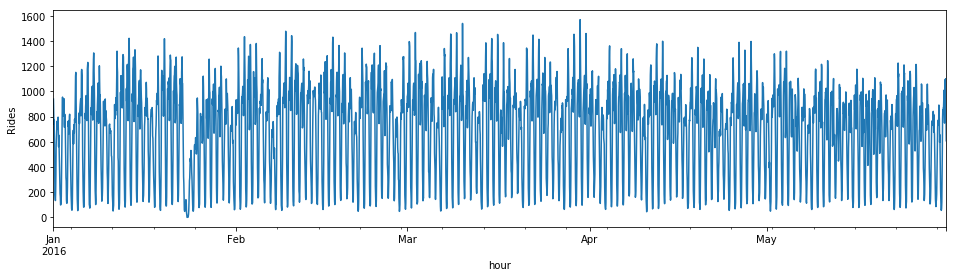

In [5]:
plt.figure(figsize=(16,4))
data.cnt.plot()
plt.ylabel('Rides')
pylab.show()

Видим значительный выскок, попробуем понять, когда он точно произошел и с каким событием связан

<Figure size 1008x144 with 0 Axes>

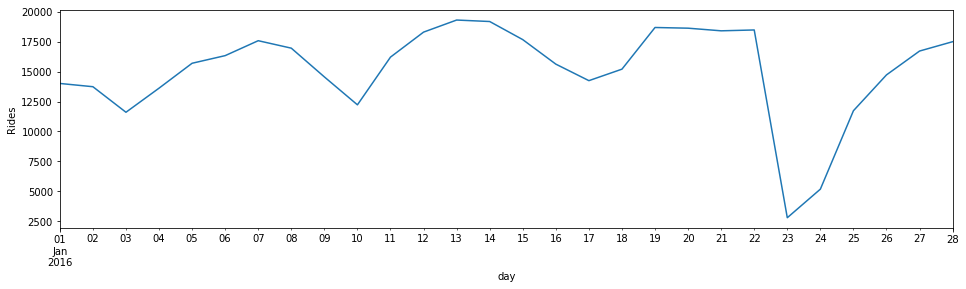

In [6]:
plt.figure(figsize=(14,2))
data['day'] = data.dt_hour.dt.floor('D') #выделим отдельно день

plt.figure(figsize=(16,4))
data.groupby(['day']).cnt.sum()[:28].plot()
plt.ylabel('Rides')
pylab.show()

Выскок произошел __23 января 2016__
В этот день на восточные штаты обрушилась крупнейшая за 100 лет снежная буря.   
http://новости-мира.ru-an.info/23-01-2016 (Снегопад века - Снегозилла)

__Попробуем найти погоду в интернете__

Файл __Weather data in New York City - 2016__  вроде подходит, хотя как источник данных не самый лучший, т.к. нельзя выбирать период  

Added for the "New York City Taxi Trip Duration" challenge  
https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016/data

In [7]:
df_weather = pd.read_csv(data_path + 'weather_data_nyc_centralpark_2016(1).csv', parse_dates=['date'], dayfirst=True)
df_weather.rename(columns={u'date':u'day'}, inplace=True)
df_weather.head(3)

,day,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,2016-01-01,42,34,38.0,0.00,0.0,0
1,2016-01-02,40,32,36.0,0.00,0.0,0
2,2016-01-03,45,35,40.0,0.00,0.0,0


In [8]:
weather_cols = ['weather_precip', 'weather_snow_fall', 'weather_avg_temp'] #столбцы погоды

In [9]:
#Т.к. минимальное ненулевое значение 0.01, а T- это trace, "след", то поставим ему 0.001 (больше 0, меньше 0.01)
df_weather['snow fall']     = df_weather['snow fall'].apply(lambda x: 0.001 if x == 'T' else float(x))
df_weather['precipitation'] = df_weather['precipitation'].apply(lambda x: 0.001 if x == 'T' else float(x))

In [10]:
#Вот наш пик снегопада
# df_weather[df_weather.day==datetime.datetime(2016,1,23)] # df_weather[df_weather.snow_fall > 2.0]

In [11]:
#Добавим столбец с снегом в данные
data['weather_snow_fall'] = np.array(pd.merge(data, df_weather, how='inner', on = ['day'])['snow fall'])
data['weather_avg_temp']  = np.array(pd.merge(data, df_weather, how='inner', on = ['day'])['average temperature'])
data['weather_precip']    = np.array(pd.merge(data, df_weather, how='inner', on = ['day'])['precipitation']).astype(float)

<function matplotlib.pyplot.show>

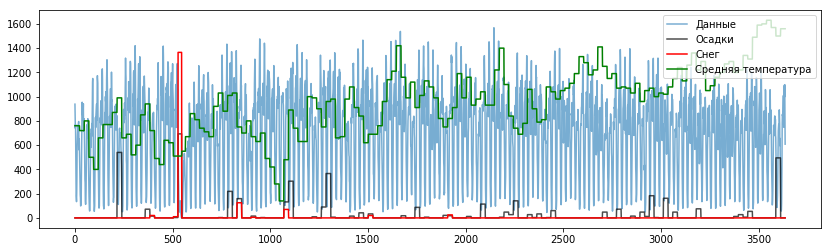

In [12]:
# Попробуем посмотрим на снег, действительно, он объясняет выскок.
plt.figure(figsize(14,4))
plt.plot(np.arange(len(data.index)), data.cnt, alpha=0.6, label=u'Данные')                           #данные 
plt.plot(np.arange(len(data.index)), data.weather_precip*300, c='k', alpha=0.7, label=u'Осадки')     #осадки
plt.plot(np.arange(len(data.index)), data.weather_snow_fall*50, c='r', label=u'Снег')                #снег
plt.plot(np.arange(len(data.index)), data.weather_avg_temp *20, c='g', label=u'Средняя температура') #средняя температура
plt.legend(loc='upper right')
plt.show

In [13]:
# Нормализация (от 0 до 1), не используем scale, т.к. отрицательные значения нам не нужны, их нет в sin и cos
data['weather_snow_fall'] = np.array(data['weather_snow_fall']) /np.array(data['weather_snow_fall']).max().astype(float)
data['weather_precip'   ] = np.array(data['weather_precip'   ]) /np.array(data['weather_precip'   ]).max().astype(float)
data['weather_avg_temp' ] = np.array(data['weather_avg_temp' ]) /np.array(data['weather_avg_temp' ]).max().astype(float)
#preprocessing.normalize(np.array(data['weather_snow_fall']).reshape(-1,1))

__Очевида связь провала в поездках и снегопада, влияние осадков как таковых не так очевидно...__

__Попробуем применить сезонные коэффициенты через дополнительные признаки__

$s_i = \sin \left( [1,\dots,T] * 2 \pi i/ 168 \right), c_i = \cos \left( [1,\dots,T] * 2 \pi i/ 168 \right), i=1,\dots, K.$

<function matplotlib.pyplot.show>

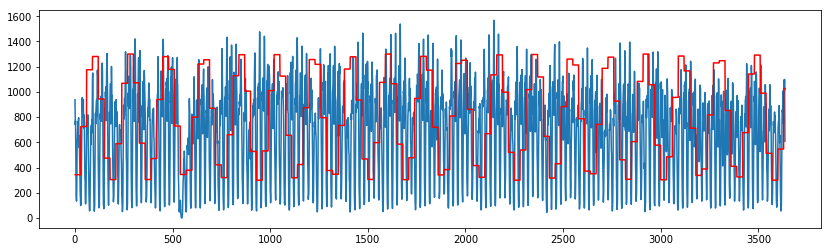

In [28]:
# Визуально отобразим аппрокисмирующую функцию
plt.figure(figsize(14,4))
plt.plot(np.arange(len(data.index)), data.cnt)  #данные 
x = np.arange(len(data.index))+1
plt.plot(x, sin(x/30-20)*500+800, c='r')   #аппроксимация синусом
plt.show

In [128]:
lr_K = 20

In [129]:
# Сделаем указанное число наборов от 1 и до K признаков для синуса и косинуса
# и заполним признаки согласно имеющейся формуле
lr_cols_all = []
rows_range = np.arange(1, len(data)+1)
for i in range(1,lr_K+1):
    col_sin = 's' + str(i)
    col_cos = 'c' + str(i)
    data[col_sin] = sin(rows_range*2*math.pi*i/168.0)
    data[col_cos] = cos(rows_range*2*math.pi*i/168.0)
    lr_cols_all.append(col_sin)
    lr_cols_all.append(col_cos)

In [130]:
lr_cols   = []
lr_scores = []
lr_resids = [] 
rows_range = np.arange(1, len(data)+1)
for i in range(1,lr_K+1):
    lr_cols.append('s' + str(i))
    lr_cols.append('c' + str(i))
    lr = linear_model.LinearRegression() #по одному признаку
    lr.fit(data[lr_cols], data.cnt)
    lr_scores.append(lr.score(data[lr_cols], data.cnt))
    lr_resids.append(data.cnt - lr.predict(data[lr_cols])) #остатки 
    if i <= 7: print 'K = ', i, '%.3f' % lr.score(data[lr_cols], data.cnt), '%.3f' % lr_scores[i-1] 

K =  1 0.034 0.034
K =  2 0.041 0.041
K =  3 0.044 0.044
K =  4 0.047 0.047
K =  5 0.053 0.053
K =  6 0.061 0.061
K =  7 0.324 0.324


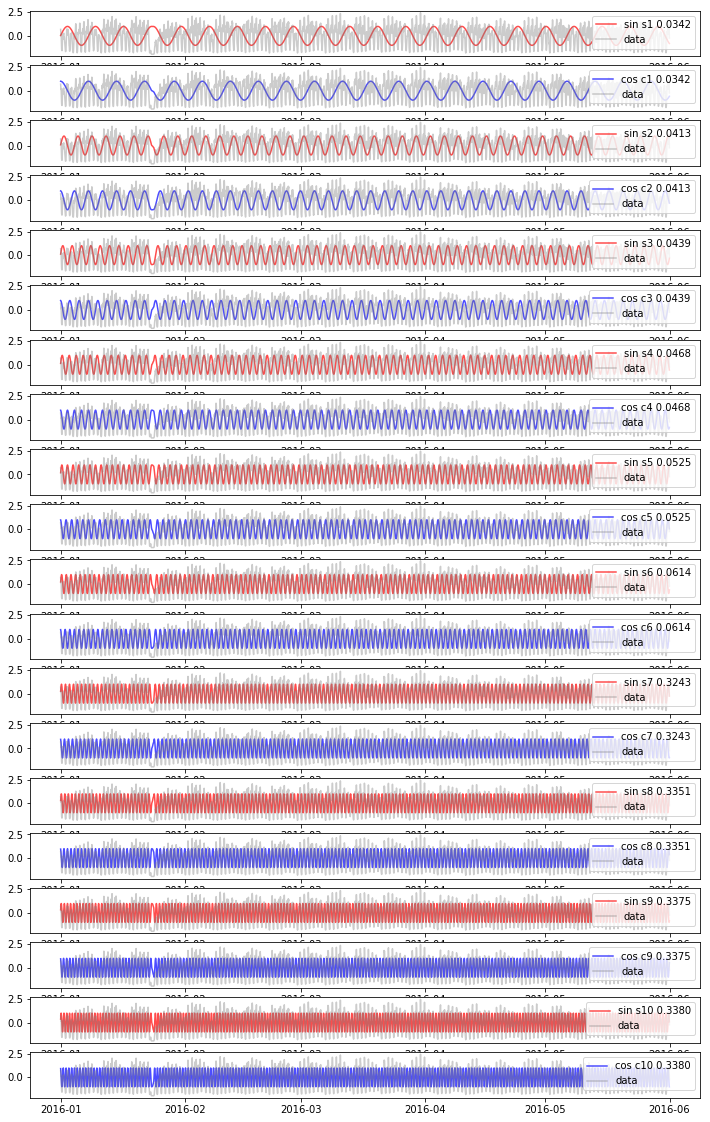

In [133]:
k = 10
f, axs = plt.subplots(nrows=len(lr_cols[:k*2]), ncols=1, figsize=(12,20))
for i, c in enumerate(lr_cols[:k*2]):
    clr = 'r' if lr_cols[i][:1]=='s' else 'b' #синусы рисуем красным, косинусы - синим
    sincos  = 'sin' if lr_cols[i][:1]=='s' else 'cos'
    axs[i].plot(data.dt_hour, data[c], c=clr, label= sincos + ' '+ c + ' %.4f'%lr_scores[i/2], alpha=0.7) #аппроксимация синусом
    axs[i].plot(data.dt_hour, preprocessing.scale(data.cnt), c='grey', alpha=0.4, label='data') 
    axs[i].legend(loc='upper right')

<function matplotlib.pyplot.show>

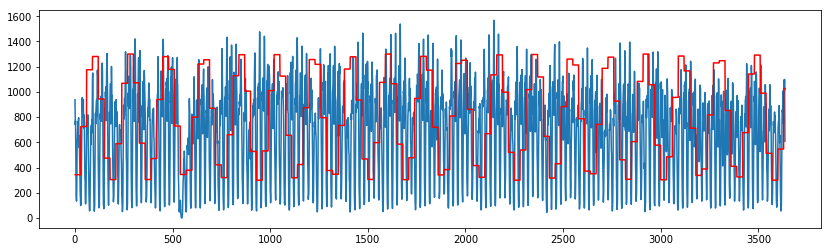

In [134]:
# Визуально отобразим аппрокисмирующую функцию
plt.figure(figsize(14,4))
plt.plot(np.arange(len(data.index)), data.cnt)  #данные 
x = np.arange(len(data.index))+1
plt.plot(x, sin(x/30-20)*500+800, c='r')   #аппроксимация синусом
plt.show

In [135]:
print lr.predict(data[lr_cols])[:5]
print np.array(data.cnt)[:5]

[913.18986819 864.81031079 794.84002652 731.12053771 694.76185241]
[938 830 739 771 560]


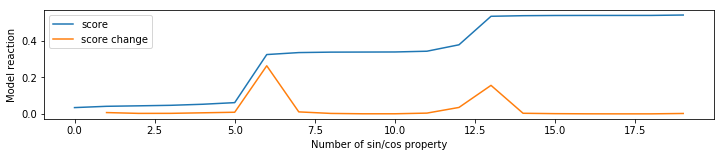

In [137]:
#Построим график изменения качества модели при разном числе тригонометрических коэффициентов для уточнения K
plt.figure(figsize(12,2))
plt.plot(lr_scores, label = 'score')
lr_scores_diff = np.array(lr_scores[1:])-np.array(lr_scores[:-1])
#продифииренцируем баллы, определим скорость изменения, вычитая из предыдщее значения для каждого балла
plt.plot(range(1, lr_K), lr_scores_diff, label = 'score change')
plt.xlabel('Number of sin/cos property')
plt.ylabel('Model reaction')
plt.legend()

In [40]:
print [ (i+1, '%.4f.' % x) for i, x in enumerate(lr_scores)]
print [ (i+1, '%.4f.' % x) for i, x in enumerate(lr_scores_diff)]

[(1, '0.0342.'), (2, '0.0413.'), (3, '0.0439.'), (4, '0.0468.'), (5, '0.0525.'), (6, '0.0614.'), (7, '0.3243.'), (8, '0.3351.'), (9, '0.3375.'), (10, '0.3380.'), (11, '0.3384.'), (12, '0.3426.'), (13, '0.3777.'), (14, '0.5335.'), (15, '0.5368.'), (16, '0.5380.'), (17, '0.5382.'), (18, '0.5383.'), (19, '0.5383.'), (20, '0.5405.')]
[(1, '0.0071.'), (2, '0.0026.'), (3, '0.0028.'), (4, '0.0058.'), (5, '0.0089.'), (6, '0.2629.'), (7, '0.0108.'), (8, '0.0024.'), (9, '0.0004.'), (10, '0.0005.'), (11, '0.0041.'), (12, '0.0351.'), (13, '0.1559.'), (14, '0.0033.'), (15, '0.0012.'), (16, '0.0003.'), (17, '0.0000.'), (18, '0.0001.'), (19, '0.0021.')]


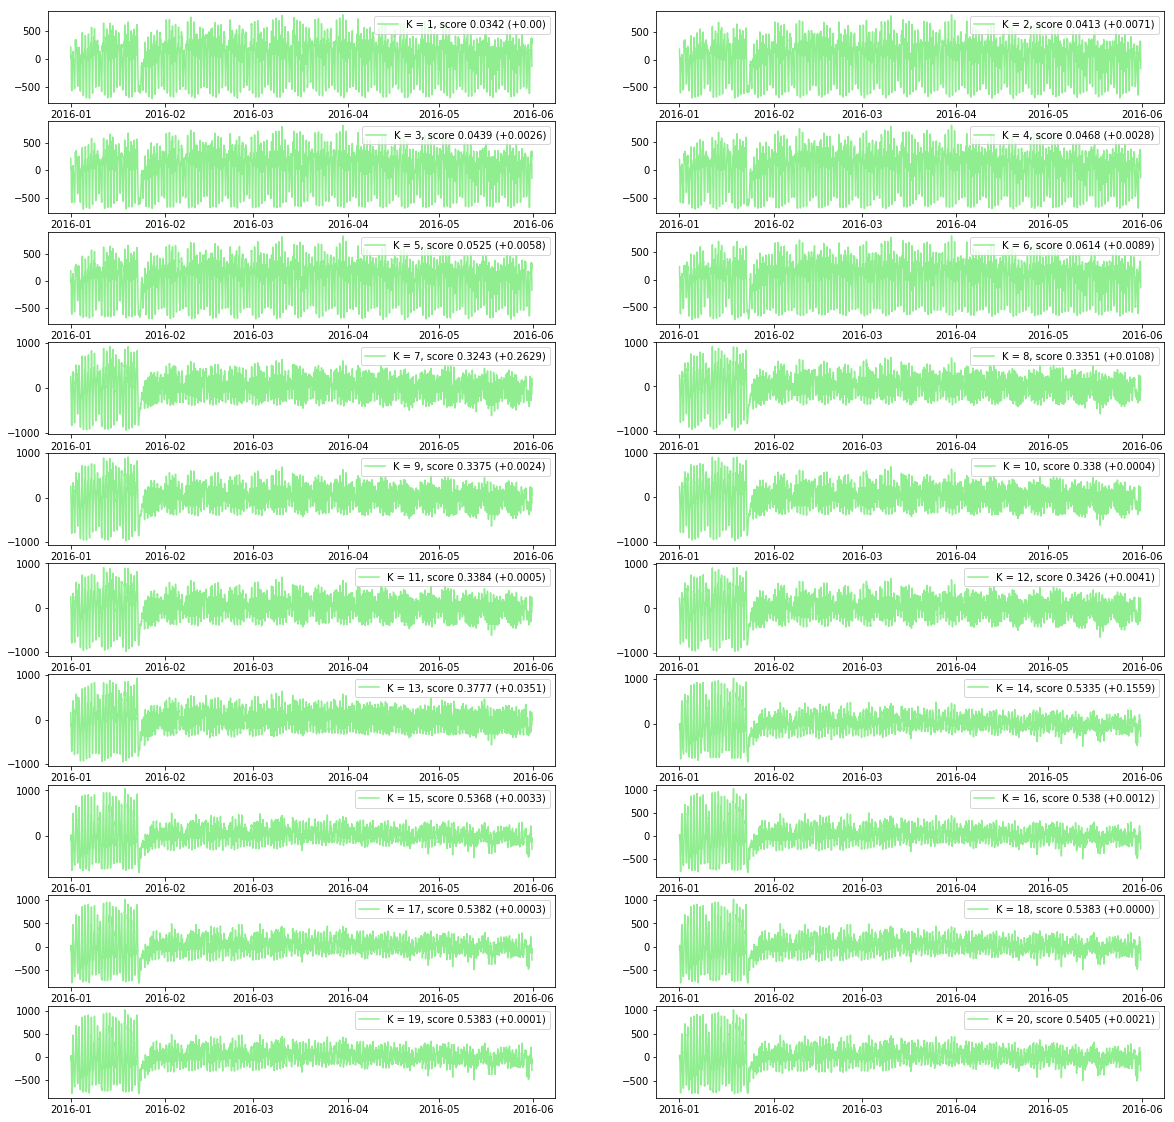

In [140]:
plt.figure(figsize(20,20))

for i, x in enumerate(lr_resids):
    plt.subplot(10, 2, i+1)
    score_diff_K = '0.00'
    if i > 0: score_diff_K = '%.4f' % lr_scores_diff[i-1]
    label_K = 'K = '+str(i+1) + ', score ' + str(round(lr_scores[i],4)) + ' (+' + score_diff_K + ')'
    plt.plot(lr_resids[i], c='lightgreen', label = label_K)
    plt.legend(loc='upper right')
    plt.show

__ Вывод по поводу K:__  
После K = 15 модель перестает существенно улучшаться (балл 0.5368)
Однако, анализ остатков показывает, что начиная с К = 7 (балл 0 .3243), модель неадекватно описывывает начало ряда. Возможно, начало ряда в плане сезонности достаточно сильно отличается от его продолжения. Однако продолжение ряда по длине намного больше начала, и модель, "подогнавшись" под основные данные - длинный хвост, довольно плохо описыает его начало. Видимо, для прогноза все же лучше взять K = 6, хотя прогноз получается не очень хороший, но равномерный на всем ряде.  

По сути, обучение на этих данных не дает хорошего результата. Провал в начале ряда слишком сильно сказывается на качестве обчуения. Возможно, надо взять больше данных, например, за два-три года, чтобы этот провал не так сказывался на обучении.

__Попробуем дополнить данные информацией о погоде, чтобы этот провал можно было учесть в модели.__

In [143]:
lrW_cols   = []
lrW_scores = []
lrW_resids = [] 
lrW_cols = lr_cols + weather_cols
for i in range(1,lr_K+1):
    lr.fit(data[lrW_cols], data.cnt)
    lrW_scores.append(lr.score(data[lrW_cols], data.cnt))
    lrW_resids.append(data.cnt - lr.predict(data[lrW_cols])) #остатки 
lrW_scores_diff = np.array(lrW_scores[1:])-np.array(lrW_scores[:-1])

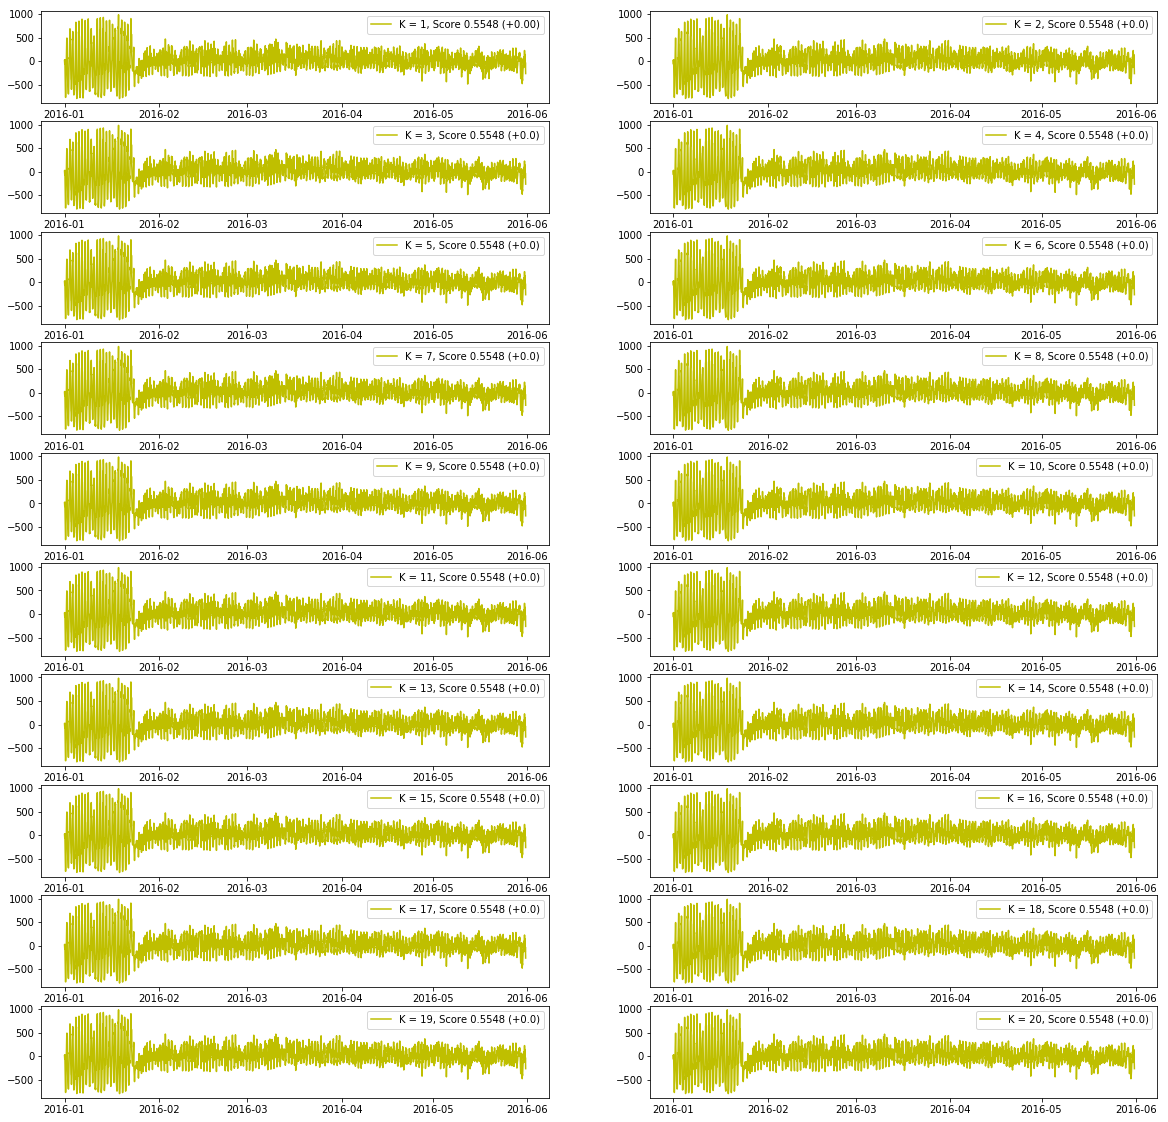

In [144]:
plt.figure(figsize(20,20))

for i, x in enumerate(lrW_resids):
    plt.subplot(10, 2, i+1)
    score_diff_K = '0.00'
    if i > 0: score_diff_K = str(round(lrW_scores_diff[i-1],4))
    label_K = 'K = '+str(i+1) + ', Score ' + str(round(lrW_scores[i],4)) + ' (+' + score_diff_K + ')'
    plt.plot(lrW_resids[i], c='y', label = label_K)
    plt.legend(loc='upper right')
    plt.show

__Учет погоды не помог... Выбираем K = 6 и идем дальше__

In [151]:
# Удалим все лишние признаки
lrSinCos_K             = 6
lrSinCos_cols          = lr_cols[:lrSinCos_K*2] # *2, т.к. для каждого K есть пара признкаов - sin и cos
lrSinCos               = lr.fit(data[lrSinCos_cols], data.cnt)
lrSinCos_score         = lrSinCos.score(data[lrSinCos_cols], data.cnt)
data['lrSinCos_cnt']   = lrSinCos.predict(data[lrSinCos_cols]) #предсаказние 
data['lrSinCos_resid'] = data.cnt - data.lrSinCos_cnt          #остатки (отклонение от предсказания)

In [154]:
print 'Признаки:', lrSinCos_cols[:2], '...', lrSinCos_cols[-4:], 'Точность:', round(lrSinCos_score,4)

Признаки: ['s1', 'c1'] ... ['s5', 'c5', 's6', 'c6'] Точность: 0.0614


__Посмотрим на остатки__

lrSinCos_resid.mean -4.25114378063e-15


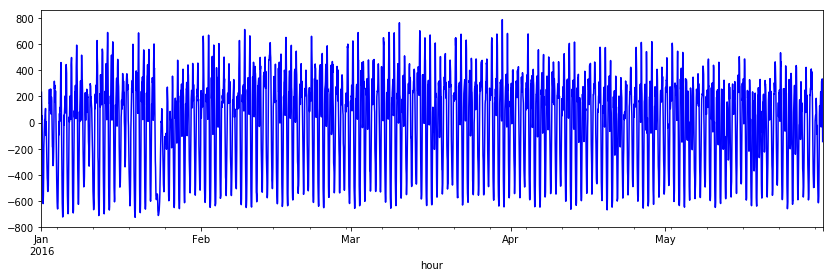

In [155]:
plt.figure(figsize(14,4))
data.lrSinCos_resid.plot(c='b')
print 'lrSinCos_resid.mean', data.lrSinCos_resid.mean()

__Остатки не имеют тренда, но в них видны внутрисуточные колебания, что нормально, мы их еще не устраняли__

In [156]:
# for i, x in enumerate(lr_resids):
#     plt.figure(figsize(12,2))
#     plt.plot(lr_resids[i], c='b', label = 'K = '+str(i+1))
#     plt.legend()
#     plt.show

In [157]:
data.head(3)

,dt_hour,cnt,day,weather_snow_fall,weather_avg_temp,weather_precip,s1,c1,s2,c2,...,s27,c27,s28,c28,s29,c29,s30,c30,lrSinCos_cnt,lrSinCos_resid
hour,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,2016-01-01 00:00:00,938,2016-01-01,0.0,0.466258,0.0,0.037391,0.999301,0.074730,0.997204,...,0.846724,0.532032,8.660254e-01,0.5,0.884115,0.467269,0.900969,0.433884,706.985712,231.014288
2016-01-01 01:00:00,2016-01-01 01:00:00,830,2016-01-01,0.0,0.466258,0.0,0.074730,0.997204,0.149042,0.988831,...,0.900969,-0.433884,8.660254e-01,-0.5,0.826239,-0.563320,0.781831,-0.623490,709.730205,120.269795
2016-01-01 02:00:00,2016-01-01 02:00:00,739,2016-01-01,0.0,0.466258,0.0,0.111964,0.993712,0.222521,0.974928,...,0.111964,-0.993712,1.224647e-16,-1.0,-0.111964,-0.993712,-0.222521,-0.974928,714.011916,24.988084


__Посмотрим на декомпозицию остатков регрессии__

<Figure size 864x720 with 0 Axes>

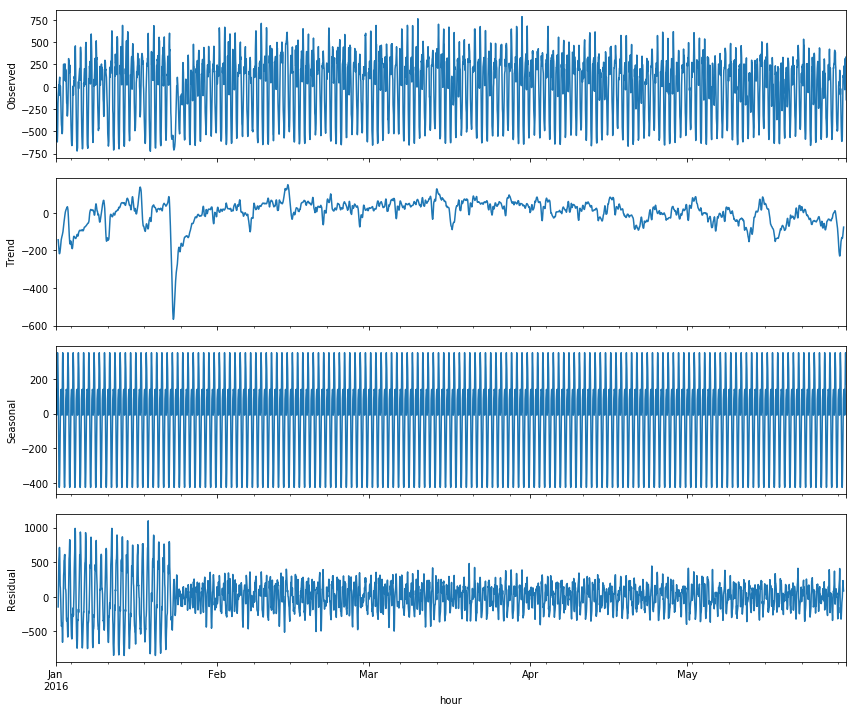

In [158]:
plt.figure(figsize(12,10))
p = sm.tsa.seasonal_decompose(data.lrSinCos_resid, freq=24).plot()

__В данных видна сезонная структура, проведем сезонную дифференицацию (по дням, сдвиг на 24 часа)__

In [159]:
data['lrSinCos_resid_diff24'] = data.lrSinCos_resid - data.lrSinCos_resid.shift(24)

<Figure size 1296x720 with 0 Axes>

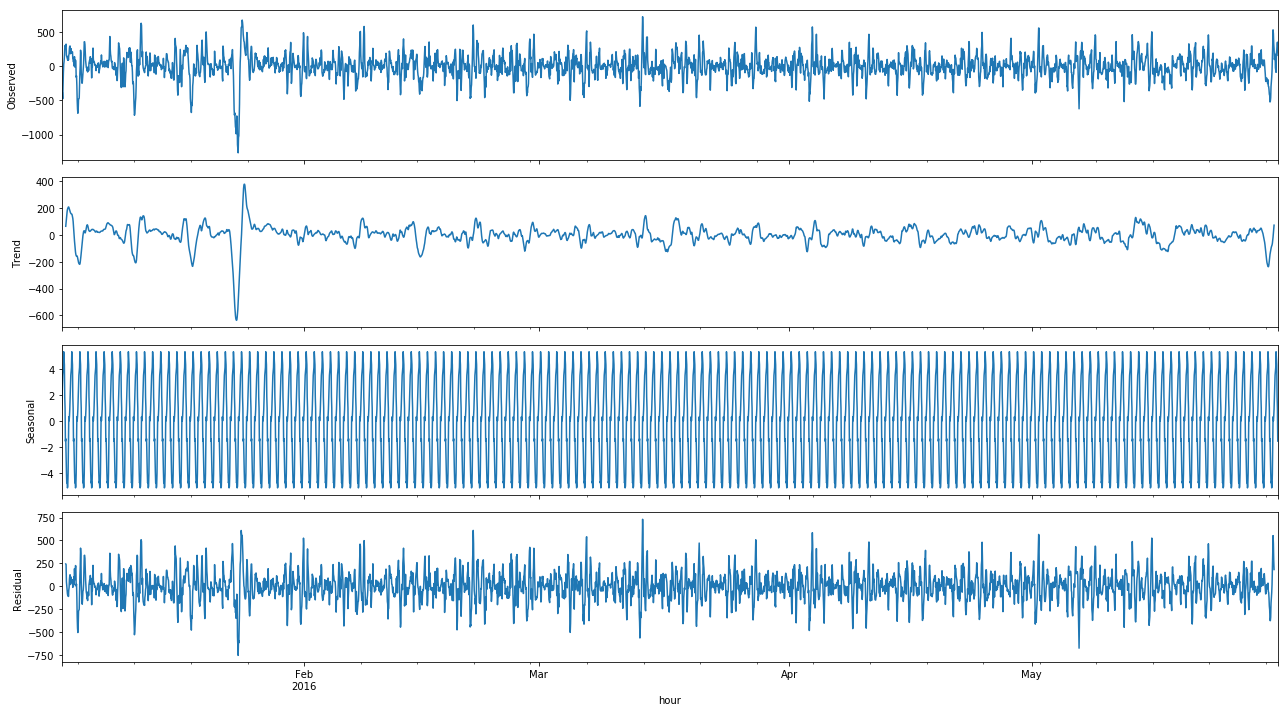

In [160]:
plt.figure(figsize(18,10))
p = sm.tsa.seasonal_decompose(data.lrSinCos_resid_diff24[24:], freq=24).plot()

In [161]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.lrSinCos_resid_diff24[24:])[1])

Критерий Дики-Фуллера: p=0.000000


__Структура из данных ушла, остатки похожи на случайные, хотя тренд довольно странный, прочем, м.б. это нормально__  
__ Критерий Дики-Фуллера уверенно отвергает нестационарность ряда__

Преобразованный ряд достаточно хорош для моделирования (обычное диффиренцирование проводить не имеет смысла)

__В данных все еще видна структура, проведем обычную дифференицацию (сдвиг на час)__

In [162]:
data['lrSinCos_resid_diff24_1'] = data.lrSinCos_resid_diff24 - data.lrSinCos_resid_diff24.shift(1)

In [163]:
print 'После диффиренцирование осталось записей:', data.lrSinCos_resid_diff24_1[24:].shape[0]

После диффиренцирование осталось записей: 3613


<Figure size 1296x720 with 0 Axes>

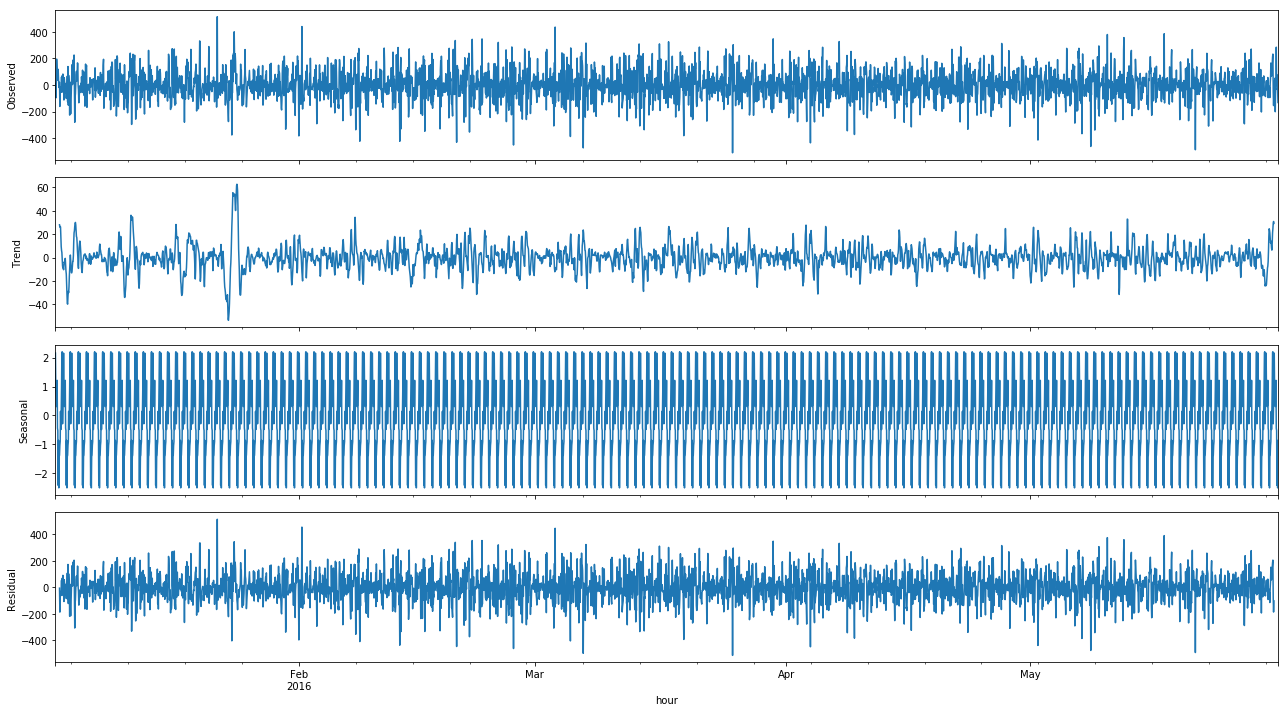

In [164]:
plt.figure(figsize(18,10))
p = sm.tsa.seasonal_decompose(data.lrSinCos_resid_diff24_1[25:], freq=24).plot()

In [165]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.lrSinCos_resid_diff24_1[25:])[1])

Критерий Дики-Фуллера: p=0.000000


In [166]:
print 'После диффиренцирование осталось записей:', data.lrSinCos_resid_diff24_1[25:].shape[0]

После диффиренцирование осталось записей: 3612


__Ряд стационарен, подбираем коэффициенты для SARIMAX__  

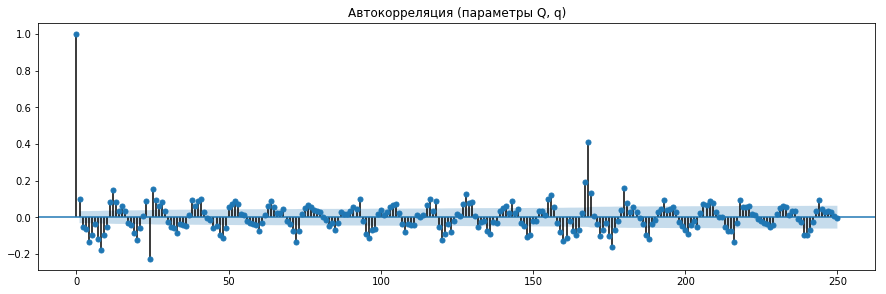

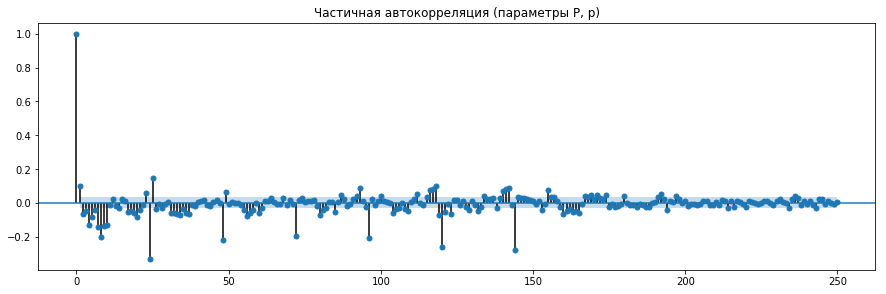

In [167]:
plt.figure(figsize(15,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.lrSinCos_resid_diff24_1[25:].values.squeeze(), 
                         lags=250, ax=ax, title=u'Автокорреляция (параметры Q, q)')
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.lrSinCos_resid_diff24_1[25:].values.squeeze(), 
                          lags=250, ax=ax, title=u'Частичная автокорреляция (параметры P, p)')
pylab.show()

In [168]:
#вообще-то принято брать ps,qs от 0, но эксперименты показали, что лучшие модели начинаются с 1-2
d  = 1              #d = 0 - обычное диффиренцирование не производилось
ps = range(2, 5)    #p = 5
qs = range(1, 2)    #q = 2

#сезонные коэффициенты
D  = 1              #D = 1 - сезонное дифференцирование выполнено
Ps = range(0, 1)    #P = 1
Qs = range(0, 2)    #Q = 2 

parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

6

__ Подобрали параметры, начинаем обучение модели__

In [169]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list: #param: ps=[0], qs=[1], Ps=[2], Qs=[3]
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    #Без преобразования data.cnt.astype(float) ругался на невозможность преобразования exog-признаков в int, глюк библиотеки
    try:
        model=sm.tsa.statespace.SARIMAX(data.cnt.astype(float),
                                        order=(param[0], d, param[1]), 
                                        #в доп. признаках учтем погоду, хотя это кардинально и не помогло
                                        exog = data[lrSinCos_cols + weather_cols], 
                                        seasonal_order=(param[2], D,  param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору 
    except ValueError: 
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model  
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')


Wall time: 14min 19s


In [22]:
# #для ускорения процесса для отладке можно применять отдельно заданные параметры
# %%time
# warnings.filterwarnings('ignore')
# try:
#     model2=sm.tsa.statespace.SARIMAX(data.cnt.astype(float), order=(3, 0, 1), seasonal_order=(1, 1, 1, 24),
#                                      exog = data[lr5_cols]).fit(disp=-1)
# except ValueError:
#     print('wrong parameters:')
# print model2.aic
# warnings.filterwarnings('default')

Wall time: 4min 37s


In [170]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters           aic
5  (4, 1, 0, 1)  42622.986861
3  (3, 1, 0, 1)  42669.149367
1  (2, 1, 0, 1)  42702.136988
4  (4, 1, 0, 0)  43588.183443
2  (3, 1, 0, 0)  43612.989876


In [171]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                                cnt   No. Observations:                 3637
Model:             SARIMAX(4, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -21289.493
Date:                            Wed, 22 May 2019   AIC                          42622.987
Time:                                    10:11:55   BIC                          42759.363
Sample:                                01-01-2016   HQIC                         42671.563
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
s1                  -83.1426      7.874    -10.559      0.000     -98.576     -67.709
c1            

__Посмотрим, насколько хорошо модель описывает данные__

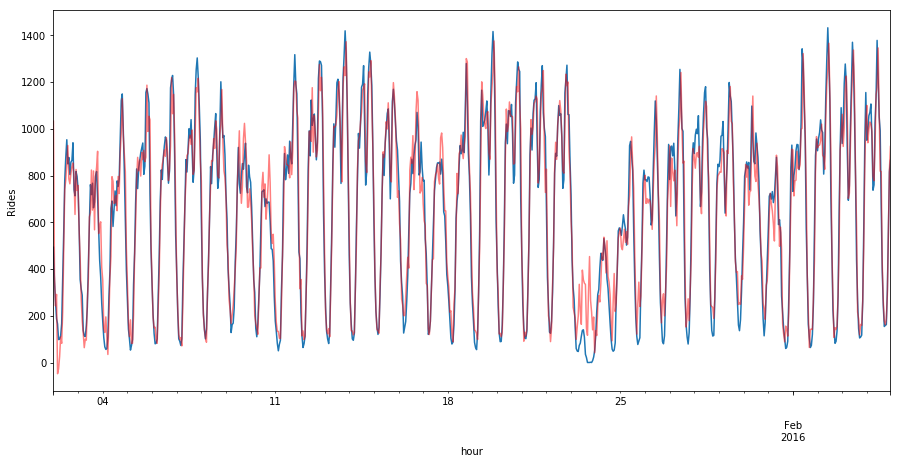

In [172]:
data['model'] = model.fittedvalues
plt.figure(figsize(15,7))
data[24:168*5].cnt.plot()
data.model[24:168*5].plot(color='r', alpha=0.5)
plt.ylabel('Rides')
pylab.show()

__В целом вроде неплохо. Посмотрим поближе__

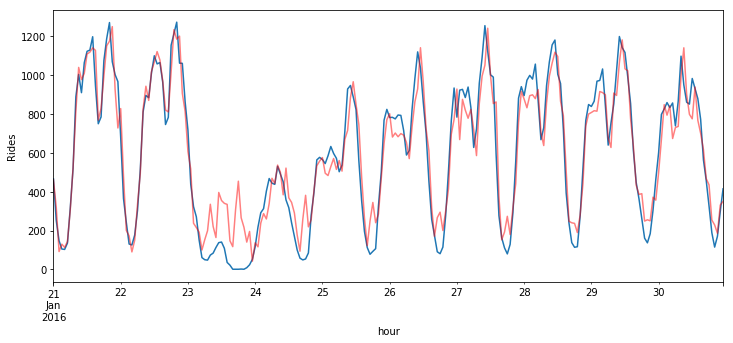

In [173]:
plt.figure(figsize(12,5))
data[24*20:24*30].cnt.plot()
data.model[24*20:24*30].plot(color='r', alpha=0.5)
plt.ylabel('Rides')
pylab.show()

__Проанализируем результаты предсказания модели__

Критерий Стьюдента: p=0.129736
Критерий Дики-Фуллера: p=0.000000


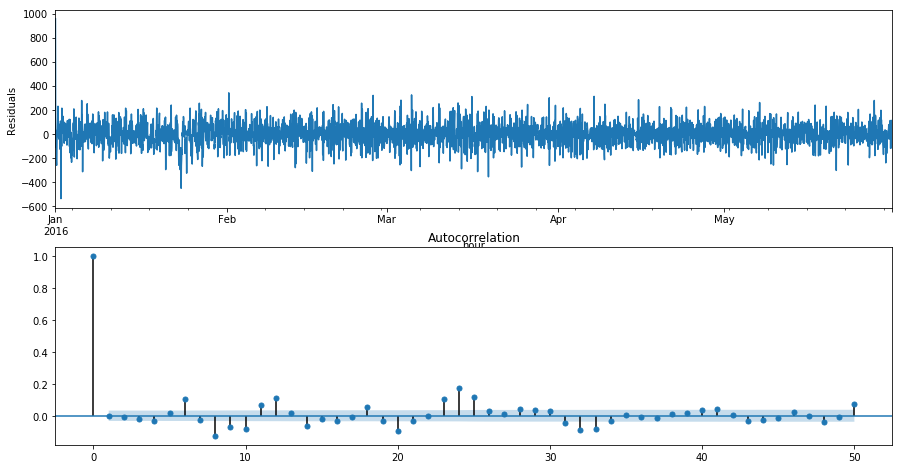

In [174]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[:].values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[24:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[:])[1])

__Оценим точность модели при помощи коэффицента детерминации $R^2$:__

In [175]:
print 'Точность модели:', round(metrics.r2_score(np.array(data.cnt), np.around(np.array(data.model),0)),2)

Точность модели: 0.94


__Вывод:__

1) остатки носят случайный характер, четкая структура не просматривается;  
2) остатки несмещены (критерий Стьюдента не может отвергнуть гипотезу о равенстве среднего остатка нулю);  
3) критерий Дики-Фуллера отвергает гипотезу о нестационарности ряда, ряд стационарен;  
4) коррелограмма остатков все еще содержит значимые лаги, автокорреляция по-прежнему присутствует.

На основе остатков модели можно предположить, что в остатках сохраняется некая структура, модель недостаточно хорошо описывает данные.
Однако на графике явно не видно каких-либо дополнительных признаков, вроде праздников, которые могут сильно улучшить модель...  

Коэффициент детерминации 0.94, что очень хорошо. Возможно, нам повезло с районом, он имеет достаточно стабильный поток поездок.